## Initialize VizDoom

In [1]:
#necessary
!pip install vizdoom
!pip install opencv-python
!pip install pandas
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install gym
!pip install pyglet==1.5.11
!pip install joblib
!pip install bayesian-optimization


# also need to install pytorch-cpu on anaconda

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


ERROR: Could not find a version that satisfies the requirement torch==1.10.1+cu113 (from versions: 1.11.0, 1.11.0+cu113, 1.12.0, 1.12.0+cu113, 1.12.1, 1.12.1+cu113, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch==1.10.1+cu113


In [2]:
# import VizDoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# import numpy for identity matrix
import numpy as np

from matplotlib import pyplot as plt

## Make it a Gym Env

In [3]:
# Import environment base class from OpenAI Gym
from gymnasium import Env
# Import gym spaces
from gymnasium.spaces import Discrete, Box
# Import Opencv for greyscaling observations
import cv2

LEVEL = 'defend_the_center'
DOOM_SKILL = ''

In [4]:
# Create VizDoom OpenAI Gym Environment
class VizDoomGym(Env): 
    def __init__(self, render=False):
        """
        Function called when we start the env.
        """

        # Inherit from Env
        super().__init__()
        
        # Set up game
        self.game = DoomGame()
        self.game.load_config('VizDoom/scenarios/basic.cfg')
        

        # Whether we want to render the game 
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()
        
        # Create action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(3)

    
    def step(self, action, frame_skip=4):
        """
        How we take a step in the environment.
        """

        # Specify action and take step
        actions = np.identity(3, dtype=np.uint8)
        total_reward = 0
        for _ in range(frame_skip):
            reward = self.game.make_action(actions[action], 5)  # Increase frame skip value here
            total_reward += reward
            
            # Break the loop if the game ends during frame skipping
            if self.game.is_episode_finished():
                break
        
        if self.game.get_state():  # if nothing is
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)  # Apply Grayscale
            ammo = self.game.get_state().game_variables[0] 
            info = ammo
        # If we don't have anything turned from game.get_state
        else:
            # Return a numpy zero array
            state = np.zeros(self.observation_space.shape)
            # Return info (game variables) as zero
            info = 0

        info = {"info": info}
        done = self.game.is_episode_finished()
        truncated = False  # Assuming it's not truncated, modify if applicable
        
        return state, total_reward, done, truncated, info


    
    def render(self):
        """
        Define how to render the game environment.
        """
        pass

    
    def reset(self, seed=None):
        """
        Function for defining what happens when we start a new game.
        """
        if seed is not None:
            self.game.set_seed(seed)
            
        self.game.new_episode()
        state = self.game.get_state().screen_buffer  # Apply Grayscale

        return self.grayscale(state), {}

    
    def grayscale(self, observation):
        """
        Function to grayscale the game frame and resize it.
        observation: gameframe
        """
        # Change colour channels 
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)

        # Reduce image pixel size for faster training
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100, 160,1))
        return state

    def close(self):
        """
        Call to close down the game.
        """
        self.game.close()


## Custom PPO model

In [5]:
# Imports

import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical


In [6]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class PPOAgent:
    def __init__(self, n_actions, input_dims, gamma, alpha, gae_lambda,
                 policy_clip, batch_size, N, n_epochs, entropy_coefficient):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

## Define Hyperparameters

In [7]:
def evaluate_hyperparameters(env, agent_params, n_games=100):
    agent = PPOAgent(**agent_params)
    total_rewards = []
    for _ in range(n_games):
        observation, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _, _ = agent.choose_action(observation)
            observation, reward, done, _, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards)
    return avg_reward

def hyperparameter_tuning():
    env = gym.make('CartPole-v1')
    #env = VizDoomGym(render=False)
    learning_rates = [0.0005, 0.0003, 0.0001]
    gammas = [0.99]
    policy_clips = [0.1, 0.2]
    entropy_coefficients = [0.00001]

    results = []
    
    for entropy_coeff in entropy_coefficients:
        for alpha in learning_rates:
            for gamma in gammas:
                for policy_clip in policy_clips:
                    agent_params = {
                        'n_actions': env.action_space.n,
                        'input_dims': env.observation_space.shape,
                        'alpha': alpha,
                        'gamma': gamma,
                        'gae_lambda': 0.95,
                        'policy_clip': policy_clip,
                        'batch_size': 64,
                        'N': 20,
                        'n_epochs': 4,
                        'entropy_coefficient': entropy_coeff
                    }
                    avg_reward = evaluate_hyperparameters(env, agent_params)
                    results.append((avg_reward, agent_params))
                    print(f'Tested {agent_params} -> Avg Reward: {avg_reward}')
    
    # Normalize rewards to sum to 1 to use as weights
    total_reward = sum([result[0] for result in results])
    weights = [result[0] / total_reward for result in results]

    # Weighted average of parameters
    avg_params = {}
    for key in results[0][1].keys():
        param_values = [params[key] for _, params in results]
        if isinstance(param_values[0], float):  # Check if the parameter is float
            avg_params[key] = sum(weight * params[key] for weight, (_, params) in zip(weights, results))
        elif isinstance(param_values[0], int):  # Check if the parameter is integer
            # Use weighted average and round it to get an integer
            weighted_sum = sum(weight * params[key] for weight, (_, params) in zip(weights, results))
            avg_params[key] = round(weighted_sum)
        else:
            # For non-numeric parameters, take the value from the best-performing configuration
            avg_params[key] = results[0][1][key]  # Assumes results is sorted by performance, best first

    print(f"Weighted Average of Best Hyperparameters: {avg_params}")
    return avg_params


## Main Loop

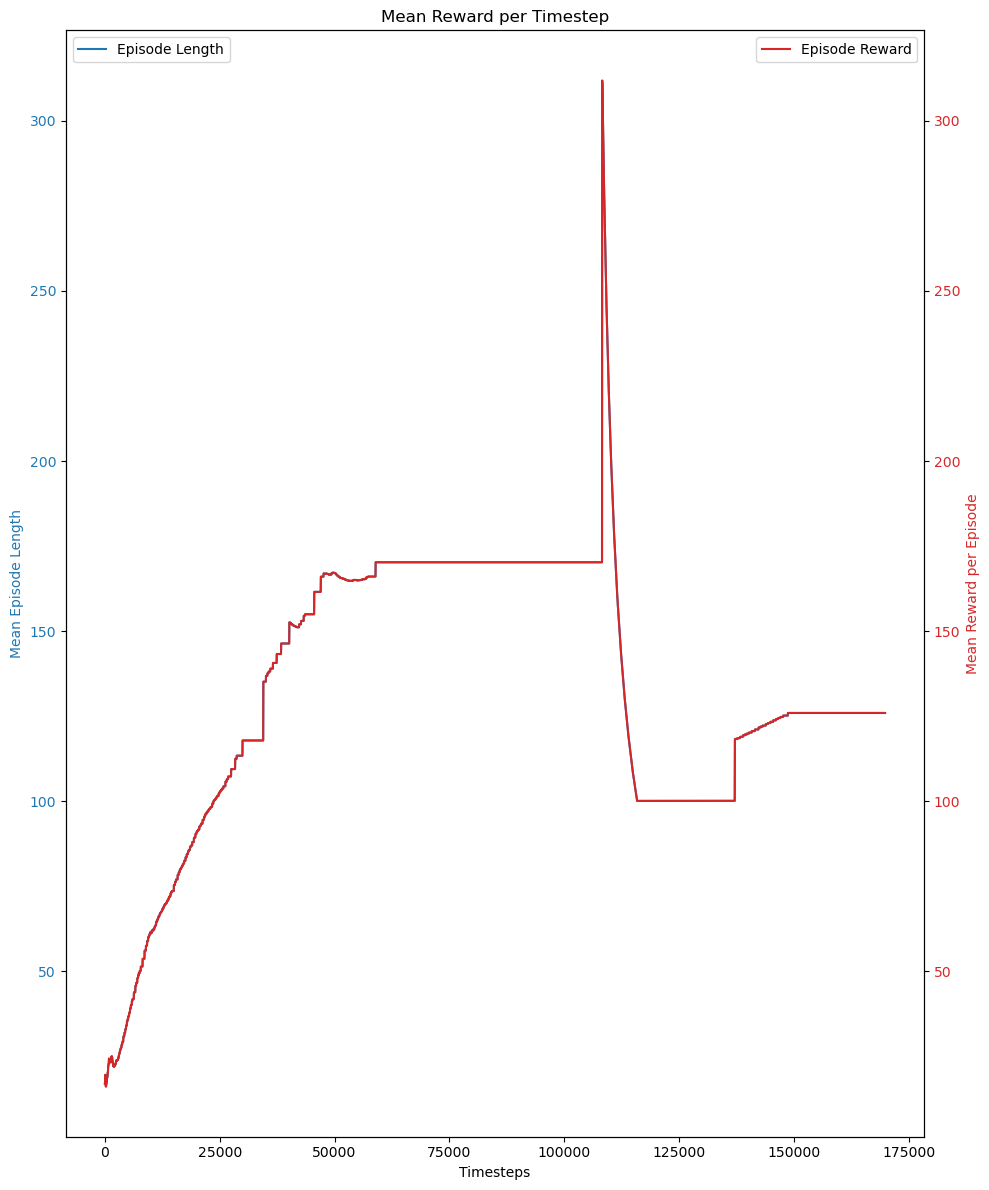

Plot saved at batch 8491 to E:\RLModelTraining\CartPole_PPO_Logs
Plot saved at batch 8491 to E:\RLModelTraining\CartPole_PPO_Logs
Batch 8491...
Episode 1180: Length = 1028, Reward = 1028.0


In [8]:
import gym
import json
import numpy as np
from IPython.display import clear_output

########################################################################################################################################################
# PLOTTING FUNCS
def plot_curve_smooth(x, scores, figure_file):
    os.makedirs(os.path.dirname(figure_file), exist_ok=True)
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])

    fig, ax = plt.subplots()  # Using subplots for consistency
    ax.plot(x, running_avg, label='Running Average')
    ax.set_xlabel('Episode')  # Align the x label
    ax.set_ylabel('Reward')  # Align the y label
    ax.legend()
    plt.title('Running Average of Previous 100 Scores')
    plt.savefig(figure_file)
    plt.show()

def smooth_curve(data, window=100):
    """Calculate the running average over a fixed window."""
    running_avg = np.zeros(len(data))
    for i in range(len(data)):
        running_avg[i] = np.mean(data[max(0, i-window):(i+1)])
    return running_avg

def plot_metrics(checkpoint_timesteps, checkpoint_avg_lengths, checkpoint_avg_rewards):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12))

    # Ensure 'episodes' is a list or array of the right size
    episodemain = list(range(1, len(checkpoint_avg_lengths) + 1))

    # Plot Episode Length and Reward
    color = 'tab:blue'
    ax1.set_ylabel('Mean Episode Length', color=color)
    ax1.set_xlabel('Timesteps')
    ax1.set_title('Mean Reward per Timestep')
    ax1.plot(checkpoint_timesteps, checkpoint_avg_lengths, color=color, label='Episode Length')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean Reward per Episode', color=color)
    ax2.plot(checkpoint_timesteps, checkpoint_avg_rewards, color=color, label='Episode Reward')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    
    # Save the plot with batch name
    plot_save_path = os.path.join(save_dir, f"plot_batch {total_batches}_metrics.png")
    #plt.savefig(plot_save_path)
    plt.show()

########################################################################################################################################################
# MAIN

if __name__ == '__main__':
    # Initialize environment
    env = gym.make('CartPole-v1')
    #env = VizDoomGym(render=True)
    best_params = hyperparameter_tuning()

    # Create the agent with the best hyperparameters
    agent = PPOAgent(**best_params)
    num_timesteps = 200000

    # Directory for saving plots and model checkpoints
    save_dir="E:\RLModelTraining\CartPole_PPO_Logs"
    os.makedirs(save_dir, exist_ok=True)

    log_path = os.path.join(save_dir, "batch_64.txt")

    # Open the log file at the beginning of the script
    out_f = open(log_path, 'w')

    # Agent loop params
    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    N = best_params.get('N', 16)

    total_timesteps = 0
    total_batches = 0
    episode_lengths = []
    episode_rewards = []
    
    checkpoint_timesteps = []
    checkpoint_avg_rewards = []
    checkpoint_avg_lengths = []

    # MAIN LOOP until total timesteps
    while total_timesteps < num_timesteps:
        observation, _ = env.reset()
        done = False
        score = 0
        
        total_reward = 0
        episode_length = 0
        
        # INNER LOOP until episode complete
        while not done and total_timesteps < num_timesteps:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info, _ = env.step(action)
            n_steps += 1
            score += reward

            total_reward += reward
            episode_length += 1
            total_timesteps += 1
            
            agent.remember(observation, action, prob, val, reward, done)

            if n_steps % N == 0:

                total_batches += 1
                # Calculate running averages of episode length and reward
                avg_episode_lengths = [np.mean(episode_lengths)]
                avg_episode_rewards = [np.mean(episode_rewards)]

                checkpoint_timesteps.append(total_timesteps)
                checkpoint_avg_rewards.append(avg_episode_rewards[-1])
                checkpoint_avg_lengths.append(avg_episode_lengths[-1])
                
                n_games = len(episode_rewards)
                episodes = range(1, n_games + 1)

                # Plotting
                
                print(f"Plot saved at batch {total_batches} to {save_dir}")
                print(f"Plot saved at batch {total_batches} to {save_dir}")
                print(f"Batch {total_batches}...")
                if episode_lengths and episode_rewards:  # Checks if lists are not empty
                    print(f"Episode {len(episode_lengths)}: Length = {episode_lengths[-1]}, Reward = {episode_rewards[-1]}")
                else:
                    print("No episodes have completed yet.")

                clear_output(wait=True)
                plot_metrics(checkpoint_timesteps, checkpoint_avg_lengths, checkpoint_avg_rewards)
                

                
                # Agent Learns
                agent.learn()
                learn_iters += 1
            observation = observation_

        episode_lengths.append(episode_length)
        episode_rewards.append(total_reward)

        n_games = len(episode_rewards)

        # Write to log
        log_data = {
            'episode': n_games,
            'reward': score,
            'total_steps': total_timesteps,
            'length': episode_length,
            'avg_score_last_100': avg_score,
            # Include other metrics if necessary
        }
        out_f.write(json.dumps(log_data) + '\n')
        out_f.flush()  # Ensure writing to file after each episode
        print(f"Episode {n_games} logged.")

        # SAVE MODEL (to checkpoint file each time agent scores better)    
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

    #report average values per however many runs

    # changed to LeakyReLU for cases of negative input
    # added entropy bonus to avoid agent converging too early, rewards more exploration - saw much better initial results
    # added hp tuning to ensure best params - as model seemed quite sensitive
    # updated hp tuning to use weighted average of model vals
    # implemented frame skipping to speed up games
    # added action space noise to force more exploration
    # add some information about CATASTROPHE FORGETTING in report. PPO is very susceptible and converges on bad policies often
